In [2]:
# Importing Libraries
import ast
import pandas as pd
import seaborn as sns
from datasets import load_dataset
import matplotlib.pyplot as plt  

# Loading Data
dataset = load_dataset('lukebarousse/data_jobs')
df = dataset['train'].to_pandas()

# Data Cleanup
df['job_posted_date'] = pd.to_datetime(df['job_posted_date'])
df['job_skills'] = df['job_skills'].apply(lambda x: ast.literal_eval(x) if pd.notna(x) else x)

In [3]:
df_DA_US = df[(df['job_title_short'] == 'Data Analyst') & (df['job_country'] == 'United States')].copy()


In [4]:
df_DA_US['job_posted_month_no'] = df_DA_US['job_posted_date'].dt.month

In [5]:
df_DA_US_exploded = df_DA_US.explode('job_skills')

In [6]:
df_DA_US_pivot = df_DA_US_exploded.pivot_table(
    index = "job_posted_month_no",
    columns = 'job_skills',
    aggfunc = 'size',
    fill_value = 0
)

df_DA_US_pivot.loc['Total'] = df_DA_US_pivot.sum()

df_DA_US_pivot = df_DA_US_pivot[df_DA_US_pivot.loc['Total'].sort_values(ascending = False).index]

df_DA_US_pivot = df_DA_US_pivot.drop('Total')

In [7]:
DA_totals = df_DA_US.groupby('job_posted_month_no').size()

In [8]:
df_DA_US_percent = df_DA_US_pivot.div(DA_totals/100, axis = 0)

In [9]:
# change month number to month name
df_DA_US_percent = df_DA_US_percent.reset_index()
df_DA_US_percent['job_posted_month'] = df_DA_US_percent['job_posted_month_no'].apply(lambda x: pd.to_datetime(x, format = '%m').strftime('%b'))
df_DA_US_percent = df_DA_US_percent.set_index('job_posted_month')
df_DA_US_percent = df_DA_US_percent.drop(columns = 'job_posted_month_no')

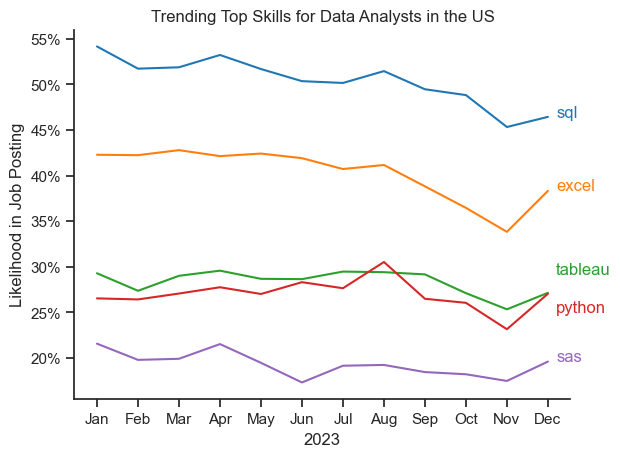

In [23]:
df_plot = df_DA_US_percent.iloc[:, :5]

sns.lineplot(
    data = df_plot,
    dashes = False,
    palette = 'tab10'
)

sns.set_theme(style = 'ticks')
sns.despine()

plt.title('Trending Top Skills for Data Analysts in the US')
plt.ylabel('Likelihood in Job Posting')
plt.xlabel('2023')
plt.legend().remove()

from matplotlib.ticker import PercentFormatter
ax = plt.gca()
ax.yaxis.set_major_formatter(PercentFormatter(decimals = 0))

# Adding text labels with the same color as the corresponding line and avoiding overlap
y_offsets = [-0.02, 0.02, 2, -2, 0]  # Adjust these offsets as needed

for i in range(5):
    y_value = df_plot.iloc[-1, i]
    y_offset = y_offsets[i % len(y_offsets)]  # Cycle through the offsets
    plt.text(11.2, y_value + y_offset, df_plot.columns[i], color=ax.lines[i].get_color())

plt.show()